In [32]:
import pandas as pd 
import numpy as nu
import datetime as dt
import matplotlib.pyplot as plt

 
df = pd.read_excel('/Users/apple/Downloads/Order_sales_Data.xlsx')
df.head()
df = pd.read_excel('/Users/apple/Downloads/Wallet_Transaction_Data.xlsx')
df.head()

,TRANSACTION_ID,CUSTOMER_ID,CUSTOMER_NAME,PHONE_NUMBER,CUSTOMER_LOCATION,HUB_NAME,DELIVERY_EXECUTIVE,TRANSACTION_TYPE,DESCRIPTION,REASON,SOURCE,TRANSACTION_DATE,TRANSACTION_TIME,AMOUNT,LAST_LEDGER_AMOUNT
0,653322,10680,Manish,9811777311,NaN,3216GUR1,Chandramani Thakur,Debit,Security Fee Debited For Order - 222704,Security Debit,Server,2024-02-13,10:30 AM,50.0,5230.0
1,653321,10680,Manish,9811777311,NaN,3216GUR1,Chandramani Thakur,Credit,Security fee debit credit for order,Security credit,Backend,2024-02-13,10:30 AM,50.0,5280.0
2,653320,7819,hemant,9717884444,NaN,3216GUR1,Chandramani Thakur,Debit,Security Fee Debited For Order - 222299,Security Debit,Server,2024-02-13,10:30 AM,150.0,5990.0
3,653319,7819,hemant,9717884444,NaN,3216GUR1,Chandramani Thakur,Credit,Security fee debit credit for order,Security credit,Backend,2024-02-13,10:30 AM,150.0,6140.0
4,653318,12280,ashish,9818537587,NaN,3217IND1,Yogesh Sah,Credit,Based on Transaction ID 653317 of amount Rs 2000,Recharge Bonus,Server,2024-02-13,10:21 AM,1000.0,4340.0


In [17]:
df_recency = df.groupby(by='CUSTOMER_NAME', 
                        as_index=False)['TRANSACTION_DATE'].max()
df_recency.columns = ['CustomerName', 'Last_transaction_Date']
recent_date = df_recency['Last_transaction_Date'].max()
df_recency['Recency'] = df_recency['Last_transaction_Date'].apply(
    lambda x: (recent_date - x).days)
df_recency.head()

,CustomerName,Last_transaction_Date,Recency
0,A K GUPTA,2024-02-13,0
1,A Sharma,2024-02-13,0
2,A kSingh,2024-01-19,25
3,AAKASH,2024-02-12,1
4,ABHILESH,2024-02-13,0


In [3]:
frequency_df = df.drop_duplicates().groupby(
    by=['CUSTOMER_NAME'], as_index=False)['TRANSACTION_DATE'].count()
frequency_df.columns = ['CustomerName', 'Frequency']
frequency_df.head()

,CustomerName,Frequency
0,A K GUPTA,194
1,A Sharma,137
2,A kSingh,56
3,AAKASH,38
4,ABHILESH,7


In [6]:

monetary_df = df.groupby(by='NAME', as_index=False)['AMOUNT'].sum()
monetary_df.columns = ['CustomerName', 'Monetary']
monetary_df.head()

,CustomerName,Monetary
0,A K GUPTA,5200
1,A Sharma,5100
2,A kSingh,3040
3,AAKASH,3040
4,ABHILESH,320


In [18]:
rf_df = df_recency.merge(frequency_df, on='CustomerName')
rfm_df = rf_df.merge(monetary_df, on='CustomerName').drop(
    columns='Last_transaction_Date')
rfm_df.head()

,CustomerName,Recency,Frequency,Monetary
0,A K GUPTA,0,194,5200
1,A Sharma,0,137,5100
2,A kSingh,25,56,3040
3,AAKASH,1,38,3040
4,ABHILESH,0,7,320


In [19]:
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)
 
# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100
 
rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
rfm_df.head()

,CustomerName,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,A K GUPTA,0,194,5200,100.000000,80.655571,80.655571
1,A Sharma,0,137,5100,100.000000,70.652174,70.652174
2,A kSingh,25,56,3040,40.754484,40.251359,40.251359
3,AAKASH,1,38,3040,73.386931,25.560462,25.560462
4,ABHILESH,0,7,320,100.000000,5.417799,5.417799


In [25]:
rfm_df['RFM_Score'] = 0.20*rfm_df['R_rank_norm']+0.25 * \
    rfm_df['F_rank_norm']+0.55*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(3)
rfm_df[['CustomerName', 'RFM_Score']].head(11)

,CustomerName,RFM_Score
0,A K GUPTA,4.226
1,A Sharma,3.826
2,A kSingh,2.018
3,AAKASH,1.756
4,ABHILESH,1.217
5,ABHISHAKE GARG,0.651
6,ABHISHEK,2.906
7,ABHISHEK ASTHANA,2.856
8,ABHISHEK SAINI,4.661
9,AJAY SINGH,2.662


In [29]:
rfm_df["Customer_segment"] = nu.where(rfm_df['RFM_Score'] >
                                      4.5, "Top Customers", 
                                      (nu.where(
                                        rfm_df['RFM_Score'] > 4,
                                        "High value Customer",
                                        (nu.where(
    rfm_df['RFM_Score'] > 3,
                             "Medium Value Customer",
                             nu.where(rfm_df['RFM_Score'] > 1.6, 
                            'Low Value Customers', 'Lost Customers'))))))
rfm_df[['CustomerName', 'RFM_Score', 'Customer_segment']].head(21)


,CustomerName,RFM_Score,Customer_segment
0,A K GUPTA,4.226,High value Customer
1,A Sharma,3.826,Medium Value Customer
2,A kSingh,2.018,Low Value Customers
3,AAKASH,1.756,Low Value Customers
4,ABHILESH,1.217,Lost Customers
5,ABHISHAKE GARG,0.651,Lost Customers
6,ABHISHEK,2.906,Low Value Customers
7,ABHISHEK ASTHANA,2.856,Low Value Customers
8,ABHISHEK SAINI,4.661,Top Customers
9,AJAY SINGH,2.662,Low Value Customers


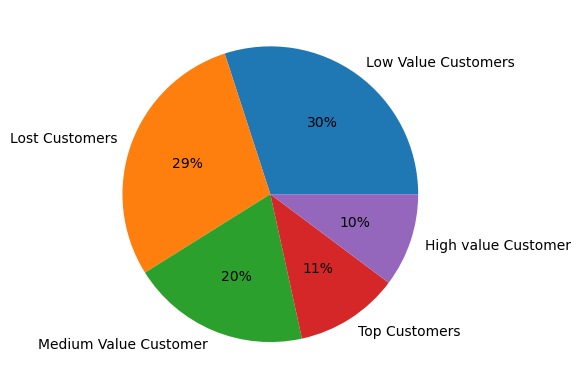

In [33]:
 plt.pie(rfm_df.Customer_segment.value_counts(),
        labels=rfm_df.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()